# Local parallelization of Hyper Parameter Search


- In this notebook, we are going to solve the same problem while using several CPUs instead of only one. The parallelization will easiely be done with joblib.
- The only part that changes is the definition of a new "optimize_study" function and piece of code w joblib ... 
- Also an example to test what is the optimal number of processes to test according to your local computer.


In [2]:
from reservoirpy.datasets import doublescroll

timesteps = 2000
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

In [3]:
train_len = 1000

X_train = X[:train_len]
y_train = X[1 : train_len + 1]

X_test = X[train_len : -1]
y_test = X[train_len + 1:]

dataset = ((X_train, y_train), (X_test, y_test))

In [4]:
from reservoirpy.observables import nrmse, rsquare

import joblib
import optuna
from optuna.storages import JournalStorage, JournalFileStorage

# Avoir having a report msg for each trial
optuna.logging.set_verbosity(optuna.logging.ERROR)

- Explain that optimization is going to be done w different trials where a simulation will be done with a configuration of hyperparameters
- Then the configuration is evaluated and stored in a database (can use different ones such as SQL ...)
- First, fix the with the values u want 

In [5]:
# Trial Fixed hyper-parameters
nb_seeds = 3
N = 500
iss = 0.9
ridge = 1e-7

- Create an objective function where simulation ... all in python syntax 

In [6]:
def objective(trial):
    # Record objective values for each trial
    rpy.verbosity(0)
    losses = []
    r2s = []

    # Trial generated parameters (with log scale)
    sr = trial.suggest_float("sr_1", 1e-2, 10, log=True)
    lr = trial.suggest_float("lr_1", 1e-3, 1, log=True)

    for seed in range(nb_seeds):
        reservoir = Reservoir(N,
                              sr=sr,
                              lr=lr,
                              input_scaling=iss,
                              seed=seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout

        # Train and test your model
        predictions = model.fit(X_train, y_train).run(X_test)

        # Compute the wanted metrics
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)

        losses.append(loss)
        r2s.append(r2)

    # TODO: ADD MULTI objective w r2s
    return np.mean(losses)

# TODO :
Change journal storage to other sql storage for example 

In [7]:
# Define study parameters
nb_trials = 200

sampler = optuna.samplers.RandomSampler() 

study_name = 'optuna_tutorial'
log_name = f"optuna-journal_{study_name}.log"

storage = JournalStorage(JournalFileStorage(log_name))

/tmp/ipykernel_3283/217699552.py:5: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(study_name))


In [8]:
nb_cpus = os.cpu_count()
print(f"Number of available CPUs : {nb_cpus}")

Number of available CPUs : 8


Create a list with number of processes to test (=nb cpus used) and a list to record their respective times for the same number of trials 

In [9]:
n_processes = [1, 2, 4, 8]
times = []

In [10]:
def optimize_study(n_trials):
    study = optuna.create_study(
        study_name='paralellization_tutorial',
        direction='minimize',
        storage=storage,
        sampler=optuna.samplers.RandomSampler(),
        load_if_exists=True
    )

    for i in range(n_trials):
        trial = study.ask()
        study.tell(trial, objective(trial))

In [11]:
for n_process in n_processes:
    print("")
    print(f"Optization with n_process = {n_process}")
    start = time.time()

    n_trials_per_process = total_trials // n_process
    args_list = [n_trials_per_process for i in range(n_process)]

    joblib.Parallel(n_jobs=n_process)(joblib.delayed(optimize_study)(args) for args in args_list)

    end = time.time()
    times.append(end - start)
    print(f"Done in {str(datetime.timedelta(seconds=end-start))}")


Optization with n_process = 1
Optimization with 1 process(es) done in 0:01:04.034894

Optization with n_process = 2


[I 2023-07-28 14:00:03,312] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:03,324] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.


Optimization with 2 process(es) done in 0:00:33.124385

Optization with n_process = 4


[I 2023-07-28 14:00:36,677] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:36,699] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:36,736] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:36,803] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.


Optimization with 4 process(es) done in 0:00:18.272678

Optization with n_process = 8


[I 2023-07-28 14:00:55,097] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,099] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,122] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,138] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,139] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,201] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,210] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,278] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.


Optimization with 8 process(es) done in 0:00:10.980919


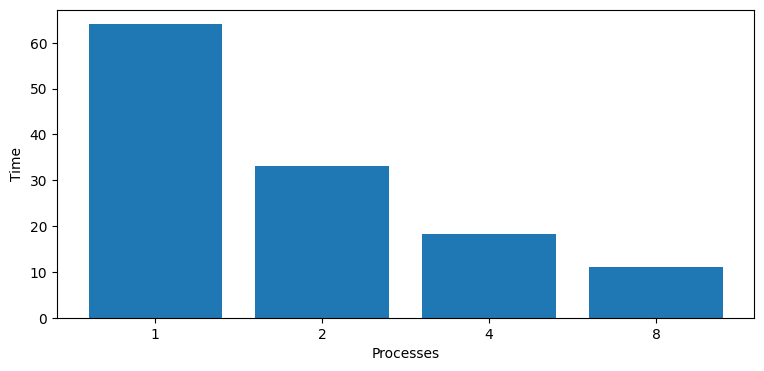

In [13]:
plt.figure(figsize=(9,4))
plt.bar(range(len(n_processes)), times)
plt.xticks(range(len(n_processes)), n_processes)
plt.xlabel("Processes")
plt.ylabel("Time")
plt.show()

- In this specific case, it seems useful to run our code on all 8 cpus if we have a complex Hyper Parameter Search to do.
- You can launch this experiment locally on your computer to see what is optimal for you and then do the experiment with the exact number of processes used.


In [14]:
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.visualization import plot_contour

In [16]:
study = optuna.load_study(
    study_name = study_name,
    storage = storage
)


In [17]:
plot_optimization_history(study)

Because random sampler, no particular improvement of the algorithm trough time. Let's see what parameters sem to be the best for this task with next plot.

In [18]:
plot_slice(study)

parallel_coordinate ugly with this example

In [19]:
plot_contour(study)